# College Scorecard Data Analysis
## Modeling Income-Share Agreements from College Outcomes Data (US Focus)
In this notebook, we are trying to model whether a school's parameters affect the outcomes of their graduates. This is essential for creating profitable income-share agreement contracts where students' financing repayments is based on their future income.

### Kaggle Kernel Notes
We used a Kaggle Kernel given the size of our dataset and the efficiency of cloud compute and cloud storage offered by the kernel.
Below are some essential notes about this Python 3 Jupyter Notebook Environment:
- It is defined by the `kaggle/python` Docker image: https://github.com/kaggle/docker-python
- Input data files are available in the read-only `../input/` directory
- You can write up to 20GB to the current directory `/kaggle/working/` that gets preserved as output when creating version 
- You can also write temporary files to `/kaggle/temp/`, but they won't be saved outside of the current session

In [1]:
import os
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns # advanced visualisations
import matplotlib.pyplot as plt # data visualisation

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max_columns', 5000) #High dimensionality data involved
warnings.simplefilter("ignore") #Only show warnings once
%matplotlib inline

/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecardDataDictionary.xlsx
/kaggle/input/college-scorecard-aggregated-dataset/InstitutionDataDocumentation.pdf
/kaggle/input/college-scorecard-aggregated-dataset/FieldOfStudyDataDocumentation.pdf
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/Most-Recent-Cohorts-Institution.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED1997_98_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/FieldOfStudyData1718_1819_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2006_07_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2011_12_PP.csv
/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data/MERGED2002_03_PP.csv
/kaggle/input/college-scorecard-aggregated-da

## Data Consolidation

In [9]:
# Define the file names for the year we want to import data for
years = [2001,2002,2003,2004,2005,2006,2007,2008,2009,2010] # Years of data we are interested in
fnames = list()

for year in years:
    fname = "/kaggle/input/college-scorecard-aggregated-dataset/CollegeScorecard_Raw_Data_09262023/data//MERGED" + str(year) + "_" + str(year+1)[2:] + "_PP.csv" #Based on format of file names
    fnames.append(fname)
print(len(fnames))

10


In [10]:
## Import first dataset – the base year dataset
data = pd.read_csv(str(fnames[0]), low_memory=False)
data["DATAYEAR"] = years[0]
dshapes = [data.shape]

## Import other datasets and concat into the base dataset
for i in range(1,len(fnames)):
    try:
        df = pd.read_csv(str(fnames[i]), low_memory=False)
        df["DATAYEAR"] = years[i]
        dshapes.append(df.shape) # Track the shape of the added data
        data = pd.concat([data, df], ignore_index=True)
    except:
        print(f"File {fnames[i]} not available")

## PrivacySuppressed has been used as an alternative to None in Object Columns    
data = data.map(lambda x: None if x == "PrivacySuppressed" else x, na_action='ignore')

## Export and visualise the data
data.to_csv("/kaggle/working/UncleanedConsolidatedData.csv")
print(data.shape, dshapes)
data.head(10)

(69360, 3233) [(6725, 3233), (6652, 3233), (6673, 3233), (6747, 3233), (6899, 3233), (6951, 3233), (6971, 3233), (7055, 3233), (7217, 3233), (7470, 3233)]


UNITID     OPEID  OPEID6                               INSTNM  \
0  100636  01230800   12308   Community College of the Air Force   
1  100654  00100200    1002             Alabama A & M University   
2  100663  00105200    1052  University of Alabama at Birmingham   
3  100690  02503400   25034                   Amridge University   
4  100706  00105500    1055  University of Alabama in Huntsville   
5  100724  00100500    1005             Alabama State University   
6  100751  00105100    1051            The University of Alabama   
7  100760  00100700    1007    Central Alabama Community College   
8  100812  00100800    1008              Athens State University   
9  100830  00831000    8310      Auburn University at Montgomery   

             CITY STABBR         ZIP  ACCREDAGENCY  INSTURL  NPCURL  SCH_DEG  \
0      Montgomery     AL  36114-3011           NaN      NaN     NaN      NaN   
1          Normal     AL       35762           NaN      NaN     NaN      3.0   
2      Birmingham     AL  35294-0110           NaN      NaN     NaN      3.0   
3      Montgomery     AL  36117-3553           NaN      NaN     NaN      3.0   
4      Huntsville     AL       35899           NaN      NaN     NaN      3.0   
5      Montgomery     AL  36104-0271           NaN      NaN     NaN      3.0   
6      Tuscaloosa     AL  35487-0100           NaN      NaN     NaN      3.0   
7  Alexander City     AL       35010           NaN      NaN     NaN      2.0   
8          Athens     AL       35611           NaN      NaN     NaN      3.0   
9      Montgomery     AL  36117-3596           NaN      NaN     NaN      3.0   

   HCM2  MAIN  NUMBRANCH  PREDDEG  HIGHDEG  CONTROL  ST_FIPS  REGION  LOCALE  \
0   NaN     1          1        2        2      1.0        1       0     NaN   
1   NaN     1          1        3        4      1.0        1       5     NaN   
2   NaN     1          1        3        4      1.0        1       5     NaN   
3   NaN     1          1        3        4      2.0        1       5     NaN   
4   NaN     1          1        3        4      1.0        1       5     NaN   
5   NaN     1          1        3        4      1.0        1       5     NaN   
6   NaN     1          1        3        4      1.0        1       5     NaN   
7   NaN     1          1        2        2      1.0        1       5     NaN   
8   NaN     1          1        3        3      1.0        1       5     NaN   
9   NaN     1          1        3        4      1.0        1       5     NaN   

   LOCALE2  LATITUDE  LONGITUDE  CCBASIC  CCUGPROF  CCSIZSET  HBCU  PBI  \
0      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
1      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
2      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
3      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
4      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
5      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
6      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
7      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
8      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   
9      NaN       NaN        NaN      NaN       NaN       NaN   NaN  NaN   

   ANNHI  TRIBAL  AANAPII  HSI  NANTI  MENONLY  WOMENONLY  RELAFFIL  ADM_RATE  \
0    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
1    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.7505   
2    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.9098   
3    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
4    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.8381   
5    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN       NaN   
6    NaN     NaN      NaN  NaN    NaN      NaN        NaN       NaN    0.7948   
7    NaN     NaN  

## Data Cleaning

In [11]:
#data = pd.read_csv("/kaggle/working/UncleanedConsolidatedData.csv", low_memory=False)

In [12]:
#PrivacySuppressed has been used as an alternative to None in Object Columns
data = data.map(lambda x: None if x == "PrivacySuppressed" else x, na_action='ignore')

#Filter data to only include data where our target variable is not not null
data.dropna(subset=['MN_EARN_WNE_P6'], inplace=True) ## Target: Mean Earning after 6 years

print(data.shape)
print(data.DATAYEAR.unique()) ## Years with our Target Variable not Null

(22122, 3233)
[2003 2005 2007 2009]


## Data Cleaning
* Impute missing values
* Encode categorical features

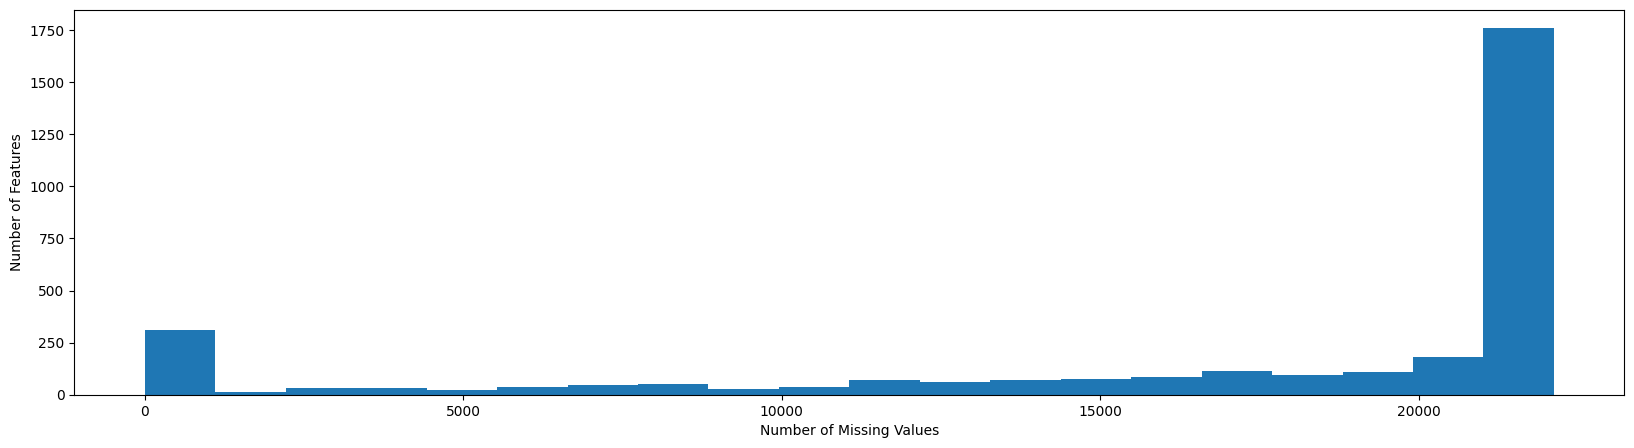

In [13]:
missing_values = data.isnull().sum(axis=0) # Identify all null values in the data
plt.figure(figsize=(20,5))
plt.hist(missing_values,bins=20,label=True)
plt.ylabel("Number of Features")
plt.xlabel("Number of Missing Values")
plt.show()

In [14]:
missing_cols = list()
threshold = 0.5 * data.shape[0] #1738 seems to be the number from 0.2 to 0.4
for column in list(data.columns):
    if data[column].isnull().sum() > threshold:
        missing_cols.append(column)
        
print(f"Drop {len(missing_cols)/data.shape[1]*100}% of the columns")

Drop 81.07021342406433% of the columns


In [15]:
data = data.drop(missing_cols,axis=1) ## Drop columns with extreme missingness
data = data.drop_duplicates() ## Drop duplicate rows

print(data.shape)
data.head()

(22122, 612)


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,ST_FIPS,REGION,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,CIP01CERT1,CIP01CERT2,CIP01ASSOC,CIP01CERT4,CIP01BACHL,CIP03CERT1,CIP03CERT2,CIP03ASSOC,CIP03CERT4,CIP03BACHL,CIP04CERT1,CIP04CERT2,CIP04ASSOC,CIP04CERT4,CIP04BACHL,CIP05CERT1,CIP05CERT2,CIP05ASSOC,CIP05CERT4,CIP05BACHL,CIP09CERT1,CIP09CERT2,CIP09ASSOC,CIP09CERT4,CIP09BACHL,CIP10CERT1,CIP10CERT2,CIP10ASSOC,CIP10CERT4,CIP10BACHL,CIP11CERT1,CIP11CERT2,CIP11ASSOC,CIP11CERT4,CIP11BACHL,CIP12CERT1,CIP12CERT2,CIP12ASSOC,CIP12CERT4,CIP12BACHL,CIP13CERT1,CIP13CERT2,CIP13ASSOC,CIP13CERT4,CIP13BACHL,CIP14CERT1,CIP14CERT2,CIP14ASSOC,CIP14CERT4,CIP14BACHL,CIP15CERT1,CIP15CERT2,CIP15ASSOC,CIP15CERT4,CIP15BACHL,CIP16CERT1,CIP16CERT2,CIP16ASSOC,CIP16CERT4,CIP16BACHL,CIP19CERT1,CIP19CERT2,CIP19ASSOC,CIP19CERT4,CIP19BACHL,CIP22CERT1,CIP22CERT2,CIP22ASSOC,CIP22CERT4,CIP22BACHL,CIP23CERT1,CIP23CERT2,CIP23ASSOC,CIP23CERT4,CIP23BACHL,CIP24CERT1,CIP24CERT2,CIP24ASSOC,CIP24CERT4,CIP24BACHL,CIP25CERT1,CIP25CERT2,CIP25ASSOC,CIP25CERT4,CIP25BACHL,CIP26CERT1,CIP26CERT2,CIP26ASSOC,CIP26CERT4,CIP26BACHL,CIP27CERT1,CIP27CERT2,CIP27ASSOC,CIP27CERT4,CIP27BACHL,CIP29CERT1,CIP29CERT2,CIP29ASSOC,CIP29CERT4,CIP29BACHL,CIP30CERT1,CIP30CERT2,CIP30ASSOC,CIP30CERT4,CIP30BACHL,CIP31CERT1,CIP31CERT2,CIP31ASSOC,CIP31CERT4,CIP31BACHL,CIP38CERT1,CIP38CERT2,CIP38ASSOC,CIP38CERT4,CIP38BACHL,CIP39CERT1,CIP39CERT2,CIP39ASSOC,CIP39CERT4,CIP39BACHL,CIP40CERT1,CIP40CERT2,CIP40ASSOC,CIP40CERT4,CIP40BACHL,CIP41CERT1,CIP41CERT2,CIP41ASSOC,CIP41CERT4,CIP41BACHL,CIP42CERT1,CIP42CERT2,CIP42ASSOC,CIP42CERT4,CIP42BACHL,CIP43CERT1,CIP43CERT2,CIP43ASSOC,CIP43CERT4,CIP43BACHL,CIP44CERT1,CIP44CERT2,CIP44ASSOC,CIP44CERT4,CIP44BACHL,CIP45CERT1,CIP45CERT2,CIP45ASSOC,CIP45CERT4,CIP45BACHL,CIP46CERT1,CIP46CERT2,CIP46ASSOC,CIP46CERT4,CIP46BACHL,CIP47CERT1,CIP47CERT2,CIP47ASSOC,CIP47CERT4,CIP47BACHL,CIP48CERT1,CIP48CERT2,CIP48ASSOC,CIP48CERT4,CIP48BACHL,CIP49CERT1,CIP49CERT2,CIP49ASSOC,CIP49CERT4,CIP49BACHL,CIP50CERT1,CIP50CERT2,CIP50ASSOC,CIP50CERT4,CIP50BACHL,CIP51CERT1,CIP51CERT2,CIP51ASSOC,CIP51CERT4,CIP51BACHL,CIP52CERT1,CIP52CERT2,CIP52ASSOC,CIP52CERT4,CIP52BACHL,CIP54CERT1,CIP54CERT2,CIP54ASSOC,CIP54CERT4,CIP54BACHL,UGDS,UGDS_NRA,UGDS_UNKN,UGDS_WHITENH,UGDS_BLACKNH,UGDS_API,UGDS_AIANOLD,UGDS_HISPOLD,PPTUG_EF,TUITIONFEE_IN,TUITIONFEE_OUT,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,C150_L4,D150_L4,UG25ABV,CDR2,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,ENRL_ORIG_YR2_RT,ENRL_4YR_TRANS_YR2_RT,ENRL_2YR_TRANS_YR2_RT,UNKN_ORIG_YR2_RT,LO_INC_COMP_ORIG_YR2_RT,LO_INC_WDRAW_ORIG_YR2_RT,LO_INC_ENRL_ORIG_YR2_RT,DEP_COMP_ORIG_YR2_RT,DEP_WDRAW_ORIG_YR2_RT,DEP_ENRL_ORIG_YR2_RT,IND_COMP_ORIG_YR2_RT,IND_WDRAW_ORIG_YR2_RT,IND_ENRL_ORIG_YR2_RT,FEMALE_COMP_ORIG_YR2_RT,FEMALE_WDRAW_ORIG_YR2_RT,FEMALE_ENRL_ORIG_YR2_RT,FEMALE_UNKN_ORIG_YR2_RT,MALE_COMP_ORIG_YR2_RT,MALE_WDRAW_ORIG_YR2_RT,MALE_ENRL_ORIG_YR2_RT,MALE_UNKN_ORIG_YR2_RT,PELL_COMP_ORIG_YR2_RT,PELL_WDRAW_ORIG_YR2_RT,PELL_ENRL_ORIG_YR2_RT,NOPELL_COMP_ORIG_YR2_RT,NOPELL_WDRAW_ORIG_YR2_RT,NOPELL_ENRL_ORIG_YR2_RT,FIRSTGEN_COMP_ORIG_YR2_RT,FIRSTGEN_WDRAW_ORIG_YR2_RT,FIRSTGEN_ENRL_ORIG_YR2_RT,FIRSTGEN_ENRL_4YR_TRANS_YR2_RT,FIRSTGEN_UNKN_ORIG_YR2_RT,NOT1STGEN_COMP_ORIG_YR2_RT,NOT1STGEN_WDRAW_ORIG_YR2_RT,NOT1STGEN_ENRL_ORIG_YR2_RT,NOT1STGEN_ENRL_4YR_TRANS_YR2_RT,NOT1STGEN_UNKN_ORIG_YR2_RT,COMP_ORIG_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,ENRL_ORIG_YR3_RT,ENRL_4YR_TRANS_YR3_RT,UNKN_ORIG_YR3_RT,LO_INC_COMP_ORIG_YR3_RT,LO_INC_WDRAW_ORIG_YR3_RT,DEP_COMP_ORIG_YR3_RT,DEP_WDRAW_ORIG_YR3_RT,IND_COMP_ORIG_YR3_RT,IND_WDRAW_ORIG_YR3_RT,FEMALE_COMP_ORIG_YR3_RT,FEMALE_WDRAW_ORIG_YR3_RT,FEMALE_UNKN_ORIG_YR3_RT,MALE_COMP_ORIG_YR3_RT,MALE_WDRAW_ORIG_YR3_RT

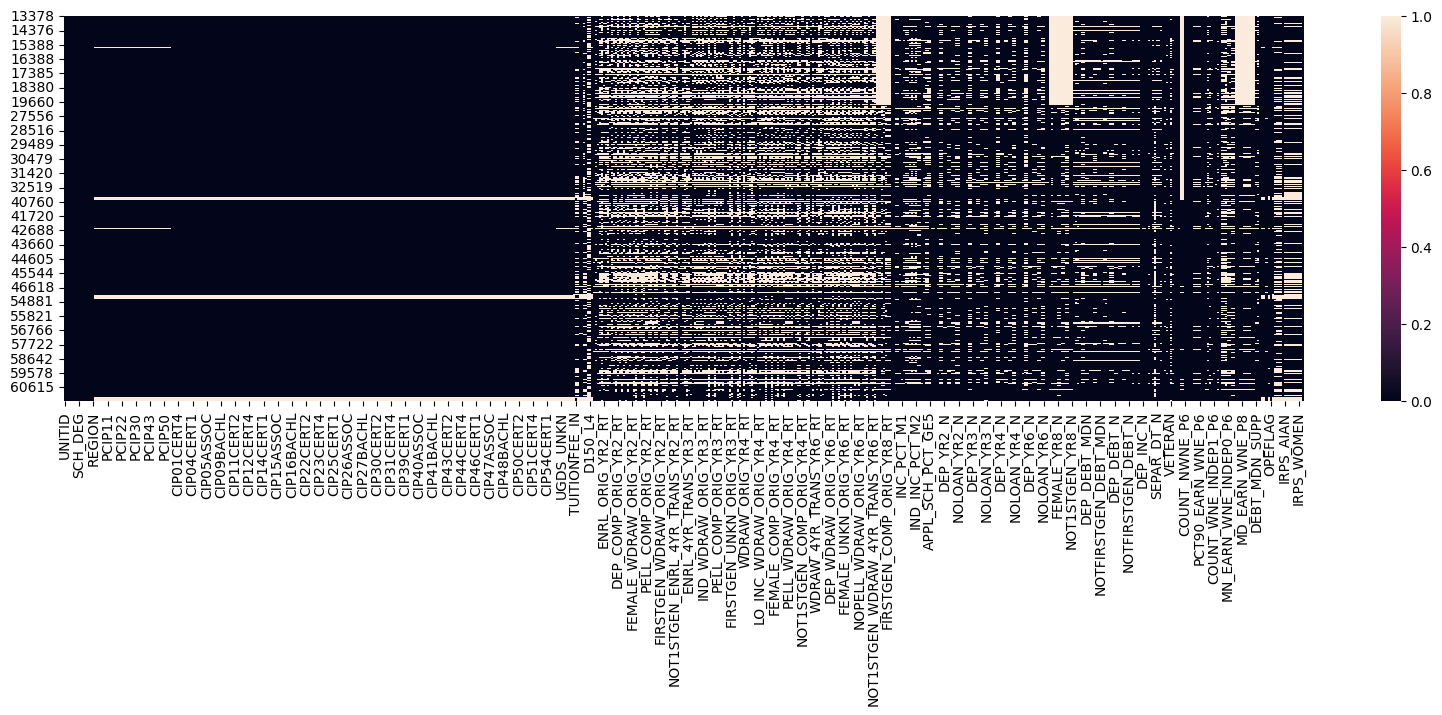

In [17]:
plt.figure(figsize=(20,5))
sns.heatmap(data.isnull())
plt.show()

In [20]:
## Drop redeundant columns and irrelevant columns: PELL, FIRSTGEN, 
to_drop = """OPEID
OPEID6
CITY
STABBR
ZIP
ST_FIPS
REGION
PELL_COMP_ORIG_YR2_RT
PELL_WDRAW_ORIG_YR2_RT
PELL_ENRL_ORIG_YR2_RT
NOPELL_COMP_ORIG_YR2_RT
NOPELL_WDRAW_ORIG_YR2_RT
NOPELL_ENRL_ORIG_YR2_RT
FIRSTGEN_COMP_ORIG_YR2_RT
FIRSTGEN_WDRAW_ORIG_YR2_RT
FIRSTGEN_ENRL_ORIG_YR2_RT
FIRSTGEN_ENRL_4YR_TRANS_YR2_RT
FIRSTGEN_UNKN_ORIG_YR2_RT
NOT1STGEN_COMP_ORIG_YR2_RT
NOT1STGEN_WDRAW_ORIG_YR2_RT
NOT1STGEN_ENRL_ORIG_YR2_RT
NOT1STGEN_ENRL_4YR_TRANS_YR2_RT
NOT1STGEN_UNKN_ORIG_YR2_RT
PELL_COMP_ORIG_YR3_RT
PELL_WDRAW_ORIG_YR3_RT
NOPELL_COMP_ORIG_YR3_RT
NOPELL_WDRAW_ORIG_YR3_RT
FIRSTGEN_COMP_ORIG_YR3_RT
FIRSTGEN_WDRAW_ORIG_YR3_RT
FIRSTGEN_ENRL_ORIG_YR3_RT
FIRSTGEN_UNKN_ORIG_YR3_RT
NOT1STGEN_COMP_ORIG_YR3_RT
NOT1STGEN_WDRAW_ORIG_YR3_RT
NOT1STGEN_ENRL_ORIG_YR3_RT
NOT1STGEN_UNKN_ORIG_YR3_RT
PELL_COMP_ORIG_YR4_RT
PELL_WDRAW_ORIG_YR4_RT
NOPELL_COMP_ORIG_YR4_RT
NOPELL_WDRAW_ORIG_YR4_RT
FIRSTGEN_COMP_ORIG_YR4_RT
FIRSTGEN_WDRAW_ORIG_YR4_RT
FIRSTGEN_WDRAW_4YR_TRANS_YR4_RT
FIRSTGEN_UNKN_ORIG_YR4_RT
NOT1STGEN_COMP_ORIG_YR4_RT
NOT1STGEN_WDRAW_ORIG_YR4_RT
NOT1STGEN_WDRAW_4YR_TRANS_YR4_RT
NOT1STGEN_UNKN_ORIG_YR4_RT
PELL_COMP_ORIG_YR6_RT
PELL_WDRAW_ORIG_YR6_RT
NOPELL_COMP_ORIG_YR6_RT
NOPELL_WDRAW_ORIG_YR6_RT
FIRSTGEN_COMP_ORIG_YR6_RT
FIRSTGEN_WDRAW_ORIG_YR6_RT
FIRSTGEN_WDRAW_4YR_TRANS_YR6_RT
FIRSTGEN_UNKN_ORIG_YR6_RT
NOT1STGEN_COMP_ORIG_YR6_RT
NOT1STGEN_WDRAW_ORIG_YR6_RT
NOT1STGEN_WDRAW_4YR_TRANS_YR6_RT
NOT1STGEN_UNKN_ORIG_YR6_RT
FIRSTGEN_COMP_ORIG_YR8_RT
NOT1STGEN_COMP_ORIG_YR8_RT
PELL_YR2_N
NOPELL_YR2_N
FIRSTGEN_YR2_N
NOT1STGEN_YR2_N
PELL_YR3_N
NOPELL_YR3_N
FIRSTGEN_YR3_N
PELL_YR4_N
NOPELL_YR4_N
FIRSTGEN_YR4_N
NOT1STGEN_YR4_N
NOPELL_YR6_N
FIRSTGEN_YR6_N
NOT1STGEN_YR6_N
PELL_YR8_N
NOPELL_YR8_N
FIRSTGEN_YR8_N
NOT1STGEN_YR8_N
PELL_DEBT_MDN
NOPELL_DEBT_MDN
FIRSTGEN_DEBT_MDN
NOTFIRSTGEN_DEBT_MDN
PELL_DEBT_N
NOPELL_DEBT_N
FIRSTGEN_DEBT_N
NOTFIRSTGEN_DEBT_N
SEPAR_DT_MDN
REPAY_DT_N
SEPAR_DT_N
PELL_EVER
FIRST_GEN"""
to_drop_cols = to_drop.split()
data = data.drop(to_drop_cols,axis=1)
data.shape

(22122, 520)

In [21]:
## Analyse data dictionary on excel and determine the numeric columns
numeric = """NUMBRANCH
PCIP01
PCIP03
PCIP04
PCIP05
PCIP09
PCIP10
PCIP11
PCIP12
PCIP13
PCIP14
PCIP15
PCIP16
PCIP19
PCIP22
PCIP23
PCIP24
PCIP25
PCIP26
PCIP27
PCIP29
PCIP30
PCIP31
PCIP38
PCIP39
PCIP40
PCIP41
PCIP42
PCIP43
PCIP44
PCIP45
PCIP46
PCIP47
PCIP48
PCIP49
PCIP50
PCIP51
PCIP52
PCIP54
UGDS
UGDS_NRA
UGDS_UNKN
UGDS_WHITENH
UGDS_BLACKNH
UGDS_API
UGDS_AIANOLD
UGDS_HISPOLD
PPTUG_EF
TUITIONFEE_IN
TUITIONFEE_OUT
TUITFTE
INEXPFTE
AVGFACSAL
PFTFAC
C150_L4
D150_L4
UG25ABV
CDR2
COMP_ORIG_YR2_RT
WDRAW_ORIG_YR2_RT
WDRAW_4YR_TRANS_YR2_RT
WDRAW_2YR_TRANS_YR2_RT
ENRL_ORIG_YR2_RT
ENRL_4YR_TRANS_YR2_RT
ENRL_2YR_TRANS_YR2_RT
UNKN_ORIG_YR2_RT
LO_INC_COMP_ORIG_YR2_RT
LO_INC_WDRAW_ORIG_YR2_RT
LO_INC_ENRL_ORIG_YR2_RT
DEP_COMP_ORIG_YR2_RT
DEP_WDRAW_ORIG_YR2_RT
DEP_ENRL_ORIG_YR2_RT
IND_COMP_ORIG_YR2_RT
IND_WDRAW_ORIG_YR2_RT
IND_ENRL_ORIG_YR2_RT
FEMALE_COMP_ORIG_YR2_RT
FEMALE_WDRAW_ORIG_YR2_RT
FEMALE_ENRL_ORIG_YR2_RT
FEMALE_UNKN_ORIG_YR2_RT
MALE_COMP_ORIG_YR2_RT
MALE_WDRAW_ORIG_YR2_RT
MALE_ENRL_ORIG_YR2_RT
MALE_UNKN_ORIG_YR2_RT
COMP_ORIG_YR3_RT
WDRAW_ORIG_YR3_RT
WDRAW_4YR_TRANS_YR3_RT
WDRAW_2YR_TRANS_YR3_RT
ENRL_ORIG_YR3_RT
ENRL_4YR_TRANS_YR3_RT
UNKN_ORIG_YR3_RT
LO_INC_COMP_ORIG_YR3_RT
LO_INC_WDRAW_ORIG_YR3_RT
DEP_COMP_ORIG_YR3_RT
DEP_WDRAW_ORIG_YR3_RT
IND_COMP_ORIG_YR3_RT
IND_WDRAW_ORIG_YR3_RT
FEMALE_COMP_ORIG_YR3_RT
FEMALE_WDRAW_ORIG_YR3_RT
FEMALE_UNKN_ORIG_YR3_RT
MALE_COMP_ORIG_YR3_RT
MALE_WDRAW_ORIG_YR3_RT
MALE_UNKN_ORIG_YR3_RT
COMP_ORIG_YR4_RT
COMP_4YR_TRANS_YR4_RT
WDRAW_ORIG_YR4_RT
WDRAW_4YR_TRANS_YR4_RT
WDRAW_2YR_TRANS_YR4_RT
ENRL_ORIG_YR4_RT
ENRL_4YR_TRANS_YR4_RT
UNKN_ORIG_YR4_RT
LO_INC_COMP_ORIG_YR4_RT
LO_INC_WDRAW_ORIG_YR4_RT
DEP_COMP_ORIG_YR4_RT
DEP_WDRAW_ORIG_YR4_RT
DEP_UNKN_ORIG_YR4_RT
IND_COMP_ORIG_YR4_RT
IND_WDRAW_ORIG_YR4_RT
IND_UNKN_ORIG_YR4_RT
FEMALE_COMP_ORIG_YR4_RT
FEMALE_WDRAW_ORIG_YR4_RT
FEMALE_UNKN_ORIG_YR4_RT
MALE_COMP_ORIG_YR4_RT
MALE_WDRAW_ORIG_YR4_RT
MALE_UNKN_ORIG_YR4_RT
COMP_ORIG_YR6_RT
COMP_4YR_TRANS_YR6_RT
WDRAW_ORIG_YR6_RT
WDRAW_4YR_TRANS_YR6_RT
WDRAW_2YR_TRANS_YR6_RT
ENRL_4YR_TRANS_YR6_RT
UNKN_ORIG_YR6_RT
LO_INC_COMP_ORIG_YR6_RT
LO_INC_WDRAW_ORIG_YR6_RT
DEP_COMP_ORIG_YR6_RT
DEP_WDRAW_ORIG_YR6_RT
DEP_UNKN_ORIG_YR6_RT
IND_COMP_ORIG_YR6_RT
IND_WDRAW_ORIG_YR6_RT
IND_UNKN_ORIG_YR6_RT
FEMALE_COMP_ORIG_YR6_RT
FEMALE_WDRAW_ORIG_YR6_RT
FEMALE_UNKN_ORIG_YR6_RT
MALE_COMP_ORIG_YR6_RT
MALE_WDRAW_ORIG_YR6_RT
MALE_UNKN_ORIG_YR6_RT
COMP_ORIG_YR8_RT
WDRAW_ORIG_YR8_RT
WDRAW_4YR_TRANS_YR8_RT
UNKN_ORIG_YR8_RT
LO_INC_COMP_ORIG_YR8_RT
INC_PCT_LO
DEP_STAT_PCT_IND
DEP_INC_PCT_LO
IND_INC_PCT_LO
PAR_ED_PCT_1STGEN
INC_PCT_M1
INC_PCT_M2
INC_PCT_H1
INC_PCT_H2
DEP_INC_PCT_M1
DEP_INC_PCT_M2
IND_INC_PCT_M1
IND_INC_PCT_M2
PAR_ED_PCT_MS
PAR_ED_PCT_HS
PAR_ED_PCT_PS
APPL_SCH_PCT_GE2
APPL_SCH_PCT_GE3
APPL_SCH_PCT_GE4
APPL_SCH_PCT_GE5
DEP_INC_AVG
IND_INC_AVG
OVERALL_YR2_N
LO_INC_YR2_N
MD_INC_YR2_N
HI_INC_YR2_N
DEP_YR2_N
IND_YR2_N
FEMALE_YR2_N
MALE_YR2_N
LOAN_YR2_N
NOLOAN_YR2_N
OVERALL_YR3_N
LO_INC_YR3_N
MD_INC_YR3_N
HI_INC_YR3_N
DEP_YR3_N
IND_YR3_N
FEMALE_YR3_N
MALE_YR3_N
LOAN_YR3_N
NOLOAN_YR3_N
NOT1STGEN_YR3_N
OVERALL_YR4_N
LO_INC_YR4_N
MD_INC_YR4_N
HI_INC_YR4_N
DEP_YR4_N
IND_YR4_N
FEMALE_YR4_N
MALE_YR4_N
LOAN_YR4_N
NOLOAN_YR4_N
OVERALL_YR6_N
LO_INC_YR6_N
MD_INC_YR6_N
HI_INC_YR6_N
DEP_YR6_N
IND_YR6_N
FEMALE_YR6_N
MALE_YR6_N
PELL_YR6_N
LOAN_YR6_N
NOLOAN_YR6_N
OVERALL_YR8_N
LO_INC_YR8_N
DEP_YR8_N
IND_YR8_N
FEMALE_YR8_N
MALE_YR8_N
LOAN_YR8_N
NOLOAN_YR8_N
DEBT_MDN
GRAD_DEBT_MDN
WDRAW_DEBT_MDN
LO_INC_DEBT_MDN
MD_INC_DEBT_MDN
HI_INC_DEBT_MDN
DEP_DEBT_MDN
IND_DEBT_MDN
FEMALE_DEBT_MDN
MALE_DEBT_MDN
DEBT_N
GRAD_DEBT_N
WDRAW_DEBT_N
LO_INC_DEBT_N
MD_INC_DEBT_N
HI_INC_DEBT_N
DEP_DEBT_N
IND_DEBT_N
FEMALE_DEBT_N
MALE_DEBT_N
CUML_DEBT_N
CUML_DEBT_P90
CUML_DEBT_P75
CUML_DEBT_P25
CUML_DEBT_P10
INC_N
DEP_INC_N
IND_INC_N
DEP_STAT_N
PAR_ED_N
APPL_SCH_N
LOAN_EVER
AGE_ENTRY
FEMALE
MARRIED
DEPENDENT
VETERAN
FAMINC
MD_FAMINC
FAMINC_IND
COUNT_NWNE_P10
COUNT_WNE_P10
COUNT_NWNE_P6
COUNT_WNE_P6
MN_EARN_WNE_P6
MD_EARN_WNE_P6
PCT10_EARN_WNE_P6
PCT25_EARN_WNE_P6
PCT75_EARN_WNE_P6
PCT90_EARN_WNE_P6
SD_EARN_WNE_P6
COUNT_WNE_INC1_P6
COUNT_WNE_INC2_P6
COUNT_WNE_INC3_P6
COUNT_WNE_INDEP0_INC1_P6
COUNT_WNE_INDEP0_P6
COUNT_WNE_INDEP1_P6
COUNT_WNE_MALE0_P6
COUNT_WNE_MALE1_P6
GT_25K_P6
MN_EARN_WNE_INC1_P6
MN_EARN_WNE_INC2_P6
MN_EARN_WNE_INC3_P6
MN_EARN_WNE_INDEP0_P6
MN_EARN_WNE_INDEP1_P6
MN_EARN_WNE_MALE0_P6
MN_EARN_WNE_MALE1_P6
COUNT_NWNE_P8
COUNT_WNE_P8
MN_EARN_WNE_P8
MD_EARN_WNE_P8
PCT10_EARN_WNE_P8
PCT25_EARN_WNE_P8
PCT75_EARN_WNE_P8
PCT90_EARN_WNE_P8
SD_EARN_WNE_P8
GT_25K_P8
DEBT_MDN_SUPP
GRAD_DEBT_MDN_SUPP
UGDS_MEN
UGDS_WOMEN
CDR2_DENOM
OPENADMP
UG12MN
BOOKSUPPLY
ROOMBOARD_OFF
OTHEREXPENSE_OFF
OTHEREXPENSE_FAM
ADMCON7
IRPS_AIAN
IRPS_ASIAN
IRPS_BLACK
IRPS_HISP
IRPS_NRA
IRPS_UNKN
IRPS_WHITE
IRPS_WOMEN
IRPS_MEN"""
numeric_cols = numeric.split()
data[numeric_cols] = data[numeric_cols].astype("float64")
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

In [22]:
boolean = """MAIN
CIP01CERT1
CIP01CERT2
CIP01ASSOC
CIP01CERT4
CIP01BACHL
CIP03CERT1
CIP03CERT2
CIP03ASSOC
CIP03CERT4
CIP03BACHL
CIP04CERT1
CIP04CERT2
CIP04ASSOC
CIP04CERT4
CIP04BACHL
CIP05CERT1
CIP05CERT2
CIP05ASSOC
CIP05CERT4
CIP05BACHL
CIP09CERT1
CIP09CERT2
CIP09ASSOC
CIP09CERT4
CIP09BACHL
CIP10CERT1
CIP10CERT2
CIP10ASSOC
CIP10CERT4
CIP10BACHL
CIP11CERT1
CIP11CERT2
CIP11ASSOC
CIP11CERT4
CIP11BACHL
CIP12CERT1
CIP12CERT2
CIP12ASSOC
CIP12CERT4
CIP12BACHL
CIP13CERT1
CIP13CERT2
CIP13ASSOC
CIP13CERT4
CIP13BACHL
CIP14CERT1
CIP14CERT2
CIP14ASSOC
CIP14CERT4
CIP14BACHL
CIP15CERT1
CIP15CERT2
CIP15ASSOC
CIP15CERT4
CIP15BACHL
CIP16CERT1
CIP16CERT2
CIP16ASSOC
CIP16CERT4
CIP16BACHL
CIP19CERT1
CIP19CERT2
CIP19ASSOC
CIP19CERT4
CIP19BACHL
CIP22CERT1
CIP22CERT2
CIP22ASSOC
CIP22CERT4
CIP22BACHL
CIP23CERT1
CIP23CERT2
CIP23ASSOC
CIP23CERT4
CIP23BACHL
CIP24CERT1
CIP24CERT2
CIP24ASSOC
CIP24CERT4
CIP24BACHL
CIP25CERT1
CIP25CERT2
CIP25ASSOC
CIP25CERT4
CIP25BACHL
CIP26CERT1
CIP26CERT2
CIP26ASSOC
CIP26CERT4
CIP26BACHL
CIP27CERT1
CIP27CERT2
CIP27ASSOC
CIP27CERT4
CIP27BACHL
CIP29CERT1
CIP29CERT2
CIP29ASSOC
CIP29CERT4
CIP29BACHL
CIP30CERT1
CIP30CERT2
CIP30ASSOC
CIP30CERT4
CIP30BACHL
CIP31CERT1
CIP31CERT2
CIP31ASSOC
CIP31CERT4
CIP31BACHL
CIP38CERT1
CIP38CERT2
CIP38ASSOC
CIP38CERT4
CIP38BACHL
CIP39CERT1
CIP39CERT2
CIP39ASSOC
CIP39CERT4
CIP39BACHL
CIP40CERT1
CIP40CERT2
CIP40ASSOC
CIP40CERT4
CIP40BACHL
CIP41CERT1
CIP41CERT2
CIP41ASSOC
CIP41CERT4
CIP41BACHL
CIP42CERT1
CIP42CERT2
CIP42ASSOC
CIP42CERT4
CIP42BACHL
CIP43CERT1
CIP43CERT2
CIP43ASSOC
CIP43CERT4
CIP43BACHL
CIP44CERT1
CIP44CERT2
CIP44ASSOC
CIP44CERT4
CIP44BACHL
CIP45CERT1
CIP45CERT2
CIP45ASSOC
CIP45CERT4
CIP45BACHL
CIP46CERT1
CIP46CERT2
CIP46ASSOC
CIP46CERT4
CIP46BACHL
CIP47CERT1
CIP47CERT2
CIP47ASSOC
CIP47CERT4
CIP47BACHL
CIP48CERT1
CIP48CERT2
CIP48ASSOC
CIP48CERT4
CIP48BACHL
CIP49CERT1
CIP49CERT2
CIP49ASSOC
CIP49CERT4
CIP49BACHL
CIP50CERT1
CIP50CERT2
CIP50ASSOC
CIP50CERT4
CIP50BACHL
CIP51CERT1
CIP51CERT2
CIP51ASSOC
CIP51CERT4
CIP51BACHL
CIP52CERT1
CIP52CERT2
CIP52ASSOC
CIP52CERT4
CIP52BACHL
CIP54CERT1
CIP54CERT2
CIP54ASSOC
CIP54CERT4
CIP54BACHL
"""
bool_cols = boolean.split()
data[bool_cols] = data[bool_cols].astype("float64")
data[bool_cols] = data[bool_cols].fillna(0)

In [23]:
ordinal = """SCH_DEG
PREDDEG
HIGHDEG
CONTROL
ICLEVEL
OPEFLAG
DATAYEAR"""
ordinal_cols = ordinal.split()
data[ordinal_cols] = data[ordinal_cols].astype("int64")
data[ordinal_cols] = data[ordinal_cols].fillna(data[ordinal_cols].mode())

In [24]:
identifiers = "UNITID INSTNM"
identifier_cols = identifiers.split()

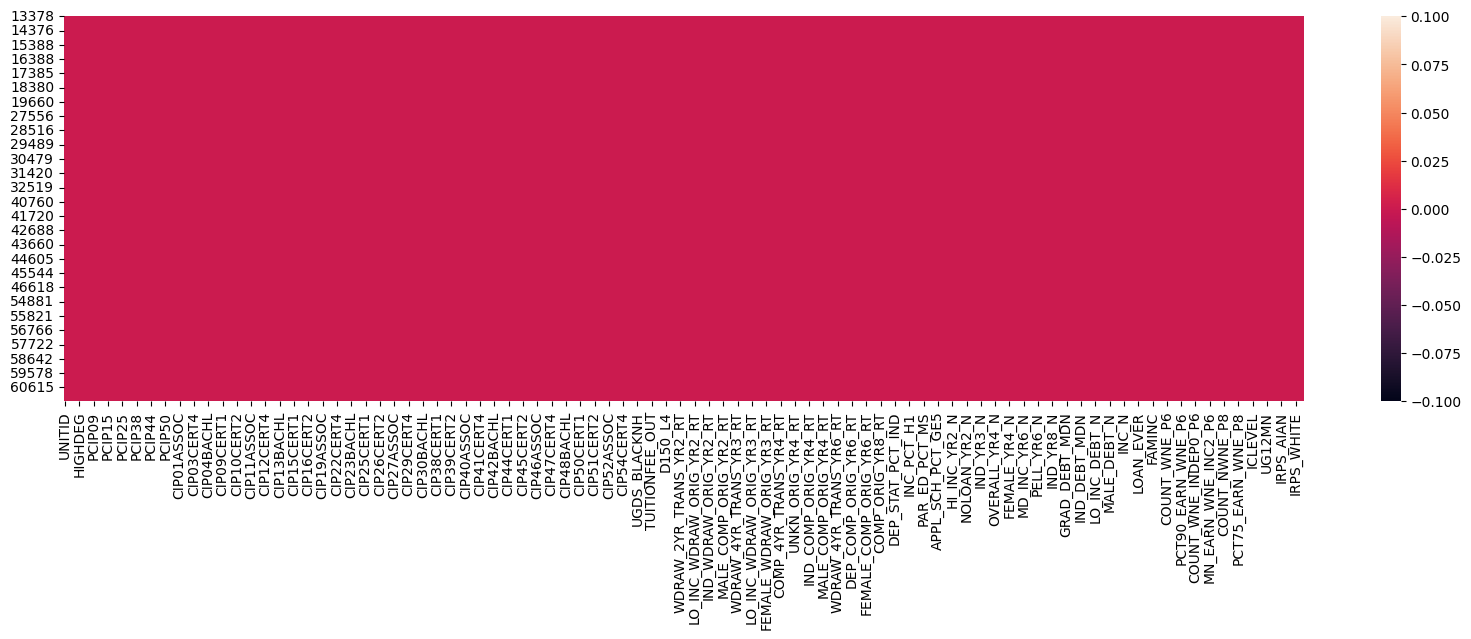

In [25]:
plt.figure(figsize=(20,5))
sns.heatmap(data.isnull())
plt.show()

In [26]:
data.to_csv("/kaggle/working/CleanedConsolidatedData.csv")

## Base Model: PCA and Regression

In [3]:
data = pd.read_csv("/kaggle/working/CleanedConsolidatedData.csv")
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,UNITID,INSTNM,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,CIP01CERT1,CIP01CERT2,CIP01ASSOC,CIP01CERT4,CIP01BACHL,CIP03CERT1,CIP03CERT2,CIP03ASSOC,CIP03CERT4,CIP03BACHL,CIP04CERT1,CIP04CERT2,CIP04ASSOC,CIP04CERT4,CIP04BACHL,CIP05CERT1,CIP05CERT2,CIP05ASSOC,CIP05CERT4,CIP05BACHL,CIP09CERT1,CIP09CERT2,CIP09ASSOC,CIP09CERT4,CIP09BACHL,CIP10CERT1,CIP10CERT2,CIP10ASSOC,CIP10CERT4,CIP10BACHL,CIP11CERT1,CIP11CERT2,CIP11ASSOC,CIP11CERT4,CIP11BACHL,CIP12CERT1,CIP12CERT2,CIP12ASSOC,CIP12CERT4,CIP12BACHL,CIP13CERT1,CIP13CERT2,CIP13ASSOC,CIP13CERT4,CIP13BACHL,CIP14CERT1,CIP14CERT2,CIP14ASSOC,CIP14CERT4,CIP14BACHL,CIP15CERT1,CIP15CERT2,CIP15ASSOC,CIP15CERT4,CIP15BACHL,CIP16CERT1,CIP16CERT2,CIP16ASSOC,CIP16CERT4,CIP16BACHL,CIP19CERT1,CIP19CERT2,CIP19ASSOC,CIP19CERT4,CIP19BACHL,CIP22CERT1,CIP22CERT2,CIP22ASSOC,CIP22CERT4,CIP22BACHL,CIP23CERT1,CIP23CERT2,CIP23ASSOC,CIP23CERT4,CIP23BACHL,CIP24CERT1,CIP24CERT2,CIP24ASSOC,CIP24CERT4,CIP24BACHL,CIP25CERT1,CIP25CERT2,CIP25ASSOC,CIP25CERT4,CIP25BACHL,CIP26CERT1,CIP26CERT2,CIP26ASSOC,CIP26CERT4,CIP26BACHL,CIP27CERT1,CIP27CERT2,CIP27ASSOC,CIP27CERT4,CIP27BACHL,CIP29CERT1,CIP29CERT2,CIP29ASSOC,CIP29CERT4,CIP29BACHL,CIP30CERT1,CIP30CERT2,CIP30ASSOC,CIP30CERT4,CIP30BACHL,CIP31CERT1,CIP31CERT2,CIP31ASSOC,CIP31CERT4,CIP31BACHL,CIP38CERT1,CIP38CERT2,CIP38ASSOC,CIP38CERT4,CIP38BACHL,CIP39CERT1,CIP39CERT2,CIP39ASSOC,CIP39CERT4,CIP39BACHL,CIP40CERT1,CIP40CERT2,CIP40ASSOC,CIP40CERT4,CIP40BACHL,CIP41CERT1,CIP41CERT2,CIP41ASSOC,CIP41CERT4,CIP41BACHL,CIP42CERT1,CIP42CERT2,CIP42ASSOC,CIP42CERT4,CIP42BACHL,CIP43CERT1,CIP43CERT2,CIP43ASSOC,CIP43CERT4,CIP43BACHL,CIP44CERT1,CIP44CERT2,CIP44ASSOC,CIP44CERT4,CIP44BACHL,CIP45CERT1,CIP45CERT2,CIP45ASSOC,CIP45CERT4,CIP45BACHL,CIP46CERT1,CIP46CERT2,CIP46ASSOC,CIP46CERT4,CIP46BACHL,CIP47CERT1,CIP47CERT2,CIP47ASSOC,CIP47CERT4,CIP47BACHL,CIP48CERT1,CIP48CERT2,CIP48ASSOC,CIP48CERT4,CIP48BACHL,CIP49CERT1,CIP49CERT2,CIP49ASSOC,CIP49CERT4,CIP49BACHL,CIP50CERT1,CIP50CERT2,CIP50ASSOC,CIP50CERT4,CIP50BACHL,CIP51CERT1,CIP51CERT2,CIP51ASSOC,CIP51CERT4,CIP51BACHL,CIP52CERT1,CIP52CERT2,CIP52ASSOC,CIP52CERT4,CIP52BACHL,CIP54CERT1,CIP54CERT2,CIP54ASSOC,CIP54CERT4,CIP54BACHL,UGDS,UGDS_NRA,UGDS_UNKN,UGDS_WHITENH,UGDS_BLACKNH,UGDS_API,UGDS_AIANOLD,UGDS_HISPOLD,PPTUG_EF,TUITIONFEE_IN,TUITIONFEE_OUT,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,C150_L4,D150_L4,UG25ABV,CDR2,COMP_ORIG_YR2_RT,WDRAW_ORIG_YR2_RT,WDRAW_4YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR2_RT,ENRL_ORIG_YR2_RT,ENRL_4YR_TRANS_YR2_RT,ENRL_2YR_TRANS_YR2_RT,UNKN_ORIG_YR2_RT,LO_INC_COMP_ORIG_YR2_RT,LO_INC_WDRAW_ORIG_YR2_RT,LO_INC_ENRL_ORIG_YR2_RT,DEP_COMP_ORIG_YR2_RT,DEP_WDRAW_ORIG_YR2_RT,DEP_ENRL_ORIG_YR2_RT,IND_COMP_ORIG_YR2_RT,IND_WDRAW_ORIG_YR2_RT,IND_ENRL_ORIG_YR2_RT,FEMALE_COMP_ORIG_YR2_RT,FEMALE_WDRAW_ORIG_YR2_RT,FEMALE_ENRL_ORIG_YR2_RT,FEMALE_UNKN_ORIG_YR2_RT,MALE_COMP_ORIG_YR2_RT,MALE_WDRAW_ORIG_YR2_RT,MALE_ENRL_ORIG_YR2_RT,MALE_UNKN_ORIG_YR2_RT,COMP_ORIG_YR3_RT,WDRAW_ORIG_YR3_RT,WDRAW_4YR_TRANS_YR3_RT,WDRAW_2YR_TRANS_YR3_RT,ENRL_ORIG_YR3_RT,ENRL_4YR_TRANS_YR3_RT,UNKN_ORIG_YR3_RT,LO_INC_COMP_ORIG_YR3_RT,LO_INC_WDRAW_ORIG_YR3_RT,DEP_COMP_ORIG_YR3_RT,DEP_WDRAW_ORIG_YR3_RT,IND_COMP_ORIG_YR3_RT,IND_WDRAW_ORIG_YR3_RT,FEMALE_COMP_ORIG_YR3_RT,FEMALE_WDRAW_ORIG_YR3_RT,FEMALE_UNKN_ORIG_YR3_RT,MALE_COMP_ORIG_YR3_RT,MALE_WDRAW_ORIG_YR3_RT,MALE_UNKN_ORIG_YR3_RT,COMP_ORIG_YR4_RT,COMP_4YR_TRANS_YR4_RT,WDRAW_ORIG_YR4_RT,WDRAW_4YR_TRANS_YR4_RT,WDRAW_2YR_TRANS_YR4_RT,ENRL_ORIG_YR4_RT,ENRL_4YR_TRANS_YR4_RT,UNKN_ORIG_YR4_RT,LO_INC_COMP_ORIG_YR4_RT,LO_INC_WDRAW_ORIG_YR4_RT,DEP_COMP_ORIG_YR4_RT,DEP_WDRAW_ORIG_YR4_RT,DEP_UNKN_ORIG_YR4_RT,IND_COMP_ORIG_YR4_RT,IND_WDRAW_ORIG_YR4_RT,IND_UNKN_ORIG_YR4_RT,FEMALE_COMP_ORIG_YR4_RT,FEMALE_WDRAW_ORIG_YR4_RT,FEMALE_UNKN_ORIG_YR4_RT,MALE_COMP_ORIG_YR4_RT,MALE_WD

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [6]:
y = data['MN_EARN_WNE_P6']
X = data.drop(['UNITID', 'INSTNM','MN_EARN_WNE_P6'],axis=1)
print(X.shape,y.shape)

(22122, 517) (22122,)


In [7]:
## Feature scaling – Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):


(17697, 517) (4425, 517) (17697,) (4425,)


In [24]:
pca = PCA(n_components = 500)
pca.fit(X_scaled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance_ratio)

[0.14798781 0.2618184  0.34334796 0.3893811  0.42009556 0.44441654
 0.46634663 0.48442824 0.49974953 0.51414369 0.52700008 0.53918057
 0.54988216 0.56000725 0.56919823 0.57718262 0.58452744 0.59169857
 0.5984248  0.60466131 0.6106831  0.6165182  0.62221548 0.62766369
 0.63302008 0.63806591 0.64298688 0.64775266 0.65240882 0.65688297
 0.66125378 0.66549632 0.66965539 0.67374314 0.67766006 0.68152703
 0.68524051 0.68885686 0.69234562 0.69579265 0.69913743 0.70236147
 0.70553045 0.70863308 0.71163343 0.71458429 0.71752337 0.72041348
 0.72319196 0.7259133  0.72860709 0.73124939 0.7338693  0.73643985
 0.73896956 0.74144824 0.74388544 0.74631459 0.7487105  0.7510735
 0.75339089 0.75569932 0.75798272 0.76023849 0.76246905 0.76464674
 0.76681474 0.76896281 0.77108281 0.77317962 0.77521859 0.77725349
 0.77925634 0.78124871 0.78322786 0.78520115 0.78715488 0.7890725
 0.79096261 0.79283324 0.79469455 0.79653592 0.79836636 0.800184
 0.80197347 0.80374113 0.80549654 0.80724667 0.80898153 0.81070833

In [36]:
print(f"70% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.7])}")
print(f"90% Explained Vairance: {len(cumulative_variance_ratio[cumulative_variance_ratio<0.9])}")

70% Explained Vairance: 41
90% Explained Vairance: 160


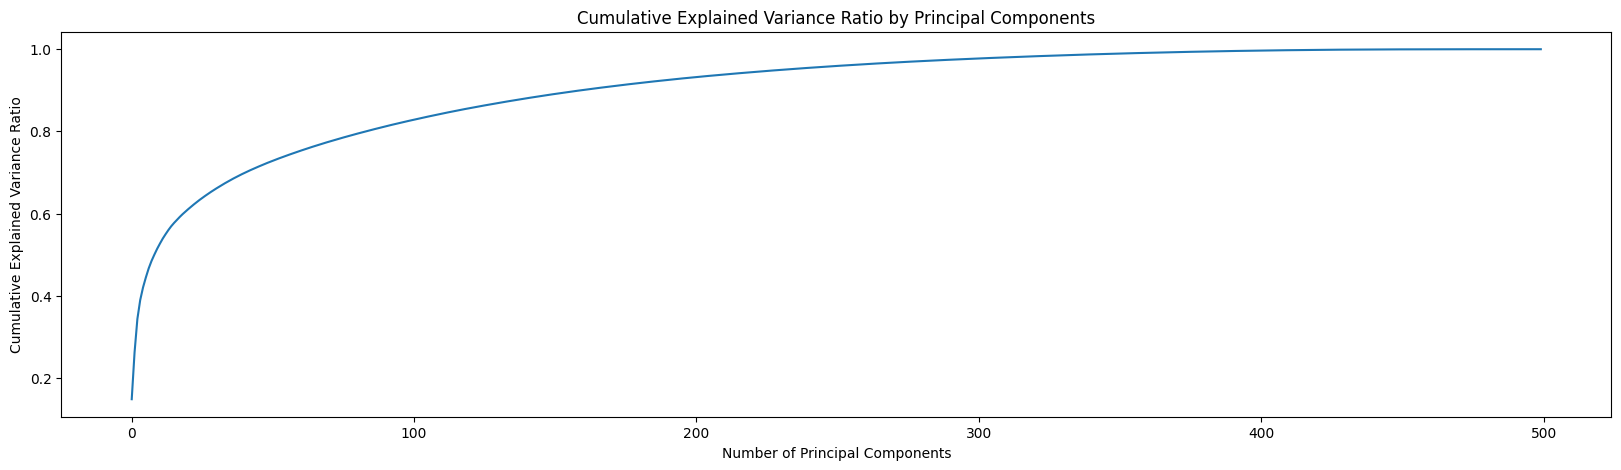

In [25]:
plt.figure(figsize=(20,5))
plt.plot(cumulative_variance_ratio)

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')

plt.show()

In [37]:
parameters = {'pca__n_components':[40,60,80,100,120,140,160]}
pipe = make_pipeline(PCA(), LinearRegression())

reg = GridSearchCV(pipe, parameters, cv=10, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)
print(reg.best_score_, reg.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/valida

-7942903.119244797 {'pca__n_components': 160}


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):


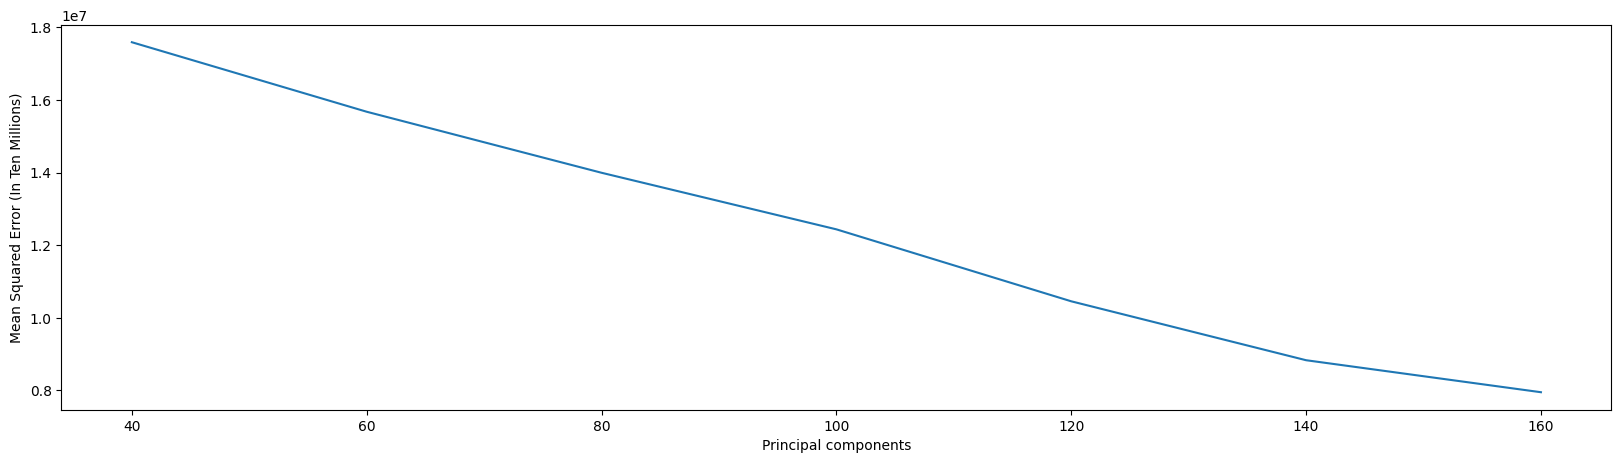

In [39]:
plt.figure(figsize=(20,5))
plt.plot(reg.cv_results_['param_pca__n_components'].data, -1 * reg.cv_results_['mean_test_score'])
plt.ylabel("Mean Squared Error (In Ten Millions)")
plt.xlabel("Principal components")
plt.show()

## Handle Multicollinearity

In [25]:
data = pd.read_csv("/kaggle/working/CleanedConsolidatedData.csv")

In [82]:
y = data['MN_EARN_WNE_P6']
df = data.drop(['Unnamed: 0', 'UNITID', 'INSTNM','Unnamed: 0.1','MN_EARN_WNE_P6'], axis=1)
df.columns

Index(['SCH_DEG', 'MAIN', 'NUMBRANCH', 'PREDDEG', 'HIGHDEG', 'CONTROL',
       'PCIP01', 'PCIP03', 'PCIP04', 'PCIP05',
       ...
       'IRPS_AIAN', 'IRPS_ASIAN', 'IRPS_BLACK', 'IRPS_HISP', 'IRPS_NRA',
       'IRPS_UNKN', 'IRPS_WHITE', 'IRPS_WOMEN', 'IRPS_MEN', 'DATAYEAR'],
      dtype='object', length=517)

In [83]:
corr = df.corr().abs()
corr.shape

(517, 517)

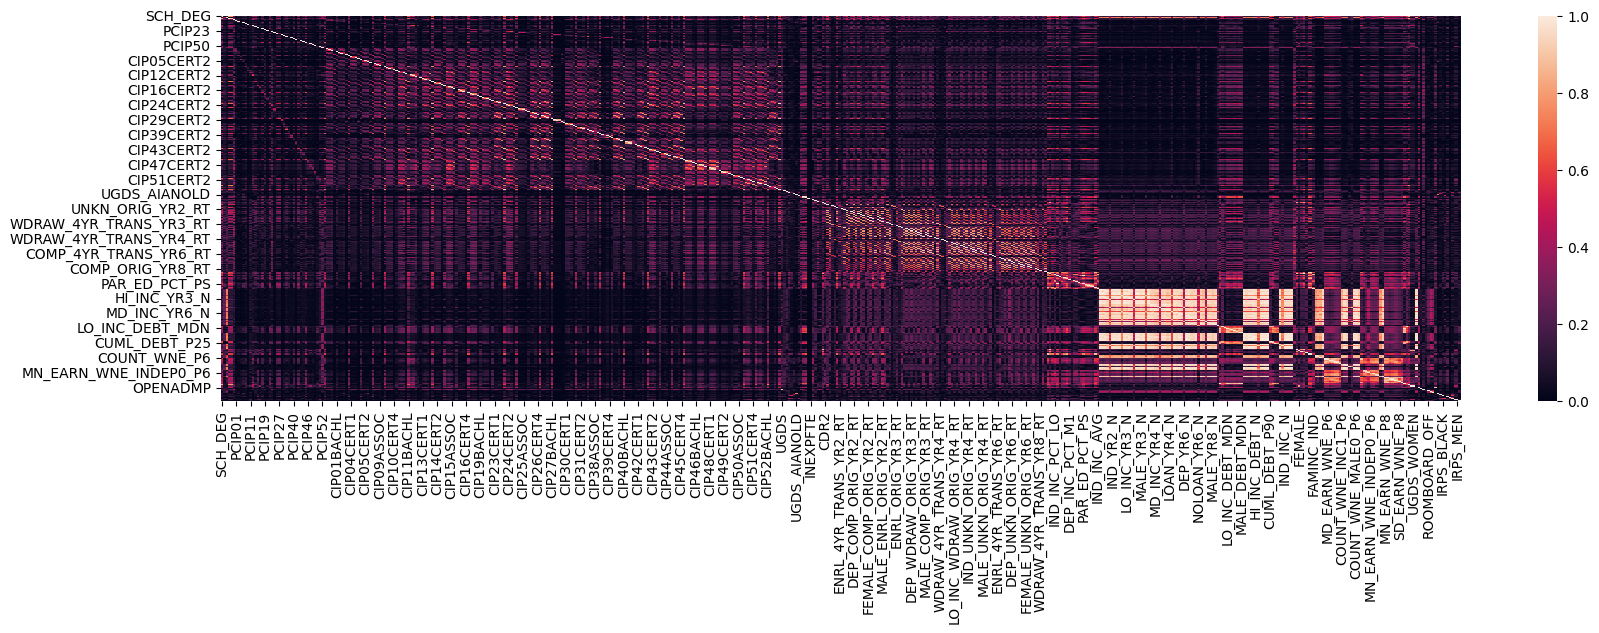

In [36]:
plt.figure(figsize=(20,5))
sns.heatmap(corr)
plt.show()

In [84]:
thresh = 0.75
corr_to_drop = list()

for i in range(len(df.columns)):
    if i not in corr_to_drop:
        mask = corr[df.columns[i]] >= thresh
        correlated = list(corr[df.columns[i]][mask].keys())
        for j in correlated:
            if j != df.columns[i] and j not in corr_to_drop:
                corr_to_drop.append(j)
                
print(len(corr_to_drop),corr_to_drop)

310 ['PREDDEG', 'HIGHDEG', 'ICLEVEL', 'OVERALL_YR4_N', 'LO_INC_YR4_N', 'MD_INC_YR4_N', 'IND_YR4_N', 'FEMALE_YR4_N', 'MALE_YR4_N', 'LOAN_YR4_N', 'MD_INC_DEBT_N', 'CDR2_DENOM', 'SCH_DEG', 'CIP52BACHL', 'CIP13BACHL', 'CIP23BACHL', 'CIP26BACHL', 'CIP27BACHL', 'CIP40BACHL', 'CIP42BACHL', 'CIP45BACHL', 'CIP54BACHL', 'CIP09BACHL', 'CIP50BACHL', 'CIP14ASSOC', 'CIP14CERT2', 'CIP38BACHL', 'CIP19ASSOC', 'CIP19CERT2', 'CIP22ASSOC', 'CIP22CERT2', 'CIP27CERT1', 'CIP27CERT2', 'CIP26CERT4', 'CIP27CERT4', 'CIP45CERT4', 'CIP16BACHL', 'CIP43CERT1', 'CIP25CERT2', 'CIP25ASSOC', 'CIP25CERT1', 'CIP40CERT1', 'CIP40CERT2', 'CIP27ASSOC', 'CIP40ASSOC', 'CIP42ASSOC', 'CIP45ASSOC', 'CIP23CERT4', 'CIP40CERT4', 'CIP23CERT1', 'CIP26CERT1', 'CIP45CERT1', 'CIP23CERT2', 'CIP26CERT2', 'CIP26ASSOC', 'CIP42CERT4', 'CIP29CERT2', 'CIP29ASSOC', 'CIP29CERT1', 'CIP41CERT2', 'CIP41ASSOC', 'CIP41CERT1', 'CIP24CERT1', 'CIP46CERT2', 'CIP46CERT1', 'CIP46ASSOC', 'CIP48CERT4', 'CIP48CERT1', 'CIP47ASSOC', 'CIP47CERT2', 'CIP47CERT1', 'C

In [85]:
df = df.drop(corr_to_drop,axis=1)
df['MN_EARN_WNE_P6'] = data['MN_EARN_WNE_P6']

print(df.shape)
df.head()

(22122, 208)


,MAIN,CONTROL,PCIP01,PCIP03,PCIP04,PCIP05,PCIP09,PCIP10,PCIP11,PCIP12,PCIP13,PCIP14,PCIP15,PCIP16,PCIP19,PCIP22,PCIP23,PCIP24,PCIP25,PCIP26,PCIP27,PCIP29,PCIP30,PCIP31,PCIP38,PCIP39,PCIP40,PCIP41,PCIP42,PCIP43,PCIP44,PCIP45,PCIP46,PCIP47,PCIP48,PCIP49,PCIP50,PCIP51,PCIP52,PCIP54,CIP01CERT1,CIP01CERT2,CIP01ASSOC,CIP01CERT4,CIP01BACHL,CIP03CERT1,CIP03CERT2,CIP03ASSOC,CIP03CERT4,CIP03BACHL,CIP04CERT1,CIP04CERT2,CIP04ASSOC,CIP04CERT4,CIP04BACHL,CIP05CERT1,CIP05CERT2,CIP05ASSOC,CIP05CERT4,CIP05BACHL,CIP09CERT1,CIP09CERT2,CIP09ASSOC,CIP09CERT4,CIP10CERT1,CIP10CERT2,CIP10ASSOC,CIP10CERT4,CIP10BACHL,CIP11CERT1,CIP11CERT2,CIP11ASSOC,CIP11CERT4,CIP12CERT1,CIP12CERT2,CIP12ASSOC,CIP12CERT4,CIP12BACHL,CIP13CERT1,CIP13CERT2,CIP13ASSOC,CIP13CERT4,CIP14CERT1,CIP14CERT4,CIP14BACHL,CIP15CERT1,CIP15CERT2,CIP15ASSOC,CIP15CERT4,CIP15BACHL,CIP16CERT1,CIP16CERT2,CIP16ASSOC,CIP16CERT4,CIP19CERT1,CIP19CERT4,CIP19BACHL,CIP22CERT1,CIP22CERT4,CIP22BACHL,CIP23ASSOC,CIP24CERT2,CIP24ASSOC,CIP24CERT4,CIP24BACHL,CIP25CERT4,CIP25BACHL,CIP29CERT4,CIP29BACHL,CIP30CERT1,CIP30CERT2,CIP30ASSOC,CIP30CERT4,CIP30BACHL,CIP31CERT1,CIP31CERT2,CIP31ASSOC,CIP31CERT4,CIP31BACHL,CIP38CERT1,CIP38CERT2,CIP38ASSOC,CIP38CERT4,CIP39CERT1,CIP39CERT2,CIP39ASSOC,CIP39CERT4,CIP39BACHL,CIP41CERT4,CIP41BACHL,CIP42CERT1,CIP42CERT2,CIP43CERT2,CIP43ASSOC,CIP43CERT4,CIP43BACHL,CIP44CERT1,CIP44CERT2,CIP44ASSOC,CIP44CERT4,CIP44BACHL,CIP45CERT2,CIP46BACHL,CIP47BACHL,CIP48BACHL,CIP49CERT4,CIP49BACHL,CIP50CERT1,CIP50CERT2,CIP50ASSOC,CIP50CERT4,CIP51BACHL,CIP54CERT1,CIP54CERT2,CIP54ASSOC,CIP54CERT4,UGDS_NRA,UGDS_UNKN,UGDS_WHITENH,UGDS_BLACKNH,UGDS_API,UGDS_AIANOLD,UGDS_HISPOLD,PPTUG_EF,TUITFTE,INEXPFTE,AVGFACSAL,PFTFAC,C150_L4,D150_L4,CDR2,WDRAW_2YR_TRANS_YR2_RT,ENRL_2YR_TRANS_YR2_RT,WDRAW_2YR_TRANS_YR3_RT,ENRL_ORIG_YR3_RT,COMP_4YR_TRANS_YR4_RT,WDRAW_2YR_TRANS_YR4_RT,ENRL_ORIG_YR4_RT,COMP_4YR_TRANS_YR6_RT,WDRAW_2YR_TRANS_YR6_RT,ENRL_4YR_TRANS_YR6_RT,WDRAW_ORIG_YR8_RT,WDRAW_4YR_TRANS_YR8_RT,INC_PCT_M1,INC_PCT_M2,DEP_INC_PCT_M1,DEP_INC_PCT_M2,IND_INC_PCT_M1,IND_INC_PCT_M2,PAR_ED_PCT_MS,PAR_ED_PCT_HS,WDRAW_DEBT_MDN,LOAN_EVER,VETERAN,OPEFLAG,BOOKSUPPLY,ROOMBOARD_OFF,OTHEREXPENSE_OFF,OTHEREXPENSE_FAM,IRPS_AIAN,IRPS_ASIAN,IRPS_BLACK,IRPS_HISP,IRPS_NRA,IRPS_UNKN,IRPS_WHITE,DATAYEAR,MN_EARN_WNE_P6
0,1.0,1,0.0496,0.0145,0.0083,0.0000,0.0000,0.0331,0.0785,0.0,0.2314,0.0393,0.0599,0.0000,0.0227,0.0,0.0021,0.0000,0.0,0.1054,0.0331,0.0,0.0000,0.0000,0.0000,0.0,0.0124,0.0,0.0372,0.0000,0.0455,0.0289,0.0,0.0,0.0,0.0,0.0062,0.0000,0.1901,0.0021,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0329,0.0000,0.0316,0.9286,0.0015,0.0017,0.0038,0.0669,3556.0,3470.0,4991.0,0.7786,0.502023,340.694096,0.124,0.026779,0.029839,0.041254,0.324257,0.023166,0.044788,0.193050,0.064655,0.029095,0.046336,0.223611,0.091886,0.179595,0.138714,0.201732,0.160606,0.086957,0.047101,0.024158,0.381386,5250.0,0.921733,0.015024,1,900.0,4500.0,2300.0,1300.0,0.0033,0.1538,0.5017,0.0033,0.0669,0.0000,0.2709,2003,30300.0
1,1.0,1,0.0000,0.0000,0.0000,0.0000,0.0447,0.0000,0.0210,0.0,0.0894,0.0480,0.0000,0.0092,0.0000,0.0,0.0204,0.0026,0.0,0.0611,0.0072,0.0,0.0000,0.0000,0.0145,0.0,0.0118,0.0,0.0901,0.0546,0.0191,0.0519,0.0,0.0,0.0,0.0,0.0414,0.1782,0.1913,0.0434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [77]:
df.to_csv("/kaggle/working/CleanedRedactedData.csv")

## Feature Selection